In [1]:
# ============================================
# Cell 1 – Imports & Config (timm backbone)
# ============================================
import os
import random
from dataclasses import dataclass
import math
import warnings

import numpy as np
from PIL import Image, ImageFilter, ImageEnhance
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.auto import tqdm

import timm

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

os.makedirs("../models", exist_ok=True)

@dataclass
class CFG:
    data_root: str = "../data/Train_Cropped"   # folder: subfolder per mahasiswa
    img_size: int = 224
    batch_size: int = 16
    num_workers: int = 0
    epochs: int = 75
    lr: float = 1e-4
    weight_decay: float = 1e-4
    label_smoothing: float = 0.1

    # ArcFace hyperparams
    arc_s: float = 25.0
    arc_m: float = 0.10

    # timm model
    model_name: str = "deit_small_patch16_224.fb_in1k"
    embedding_dim: int = 512

    val_ratio: float = 0.2
    seed: int = 32

CFG = CFG()
print(CFG)


d:\Perkuliahan\Sem 7\Pembelajaran Mendalam\Tubes 2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
CFG(data_root='../data/Train_Cropped', img_size=224, batch_size=16, num_workers=0, epochs=75, lr=0.0001, weight_decay=0.0001, label_smoothing=0.1, arc_s=25.0, arc_m=0.1, model_name='deit_small_patch16_224.fb_in1k', embedding_dim=512, val_ratio=0.2, seed=32)


In [2]:
# ============================================
# Cell 2 – Fix Seed
# ============================================
def set_seed(seed: int = 32):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)
print("Seed set to:", CFG.seed)


Seed set to: 32


In [3]:
# -----------------------------
# CUSTOM FUNCTIONS
# -----------------------------
def add_gaussian_noise(img, std=0.05):
    arr = np.array(img).astype(np.float32) / 255.0
    noise = np.random.normal(0, std, arr.shape)
    arr = np.clip(arr + noise, 0, 1)
    return Image.fromarray((arr * 255).astype(np.uint8))

def add_multiplicative_noise(img, minv=0.9, maxv=1.1):
    arr = np.array(img).astype(np.float32) / 255.0
    mult = np.random.uniform(minv, maxv)
    arr = np.clip(arr * mult, 0, 1)
    return Image.fromarray((arr * 255).astype(np.uint8))

def iso_noise(img):
    arr = np.array(img).astype(np.float32)
    noise = np.random.normal(0, 12, arr.shape) + np.random.normal(0, 2, arr.shape) * arr / 255
    arr = np.clip(arr + noise, 0, 255)
    return Image.fromarray(arr.astype(np.uint8))

def motion_blur(img, degree=5):
    img = np.array(img)
    kernel = np.zeros((degree, degree))
    kernel[int((degree-1)/2), :] = np.ones(degree)
    kernel = kernel / degree
    blurred = cv2.filter2D(img, -1, kernel)
    return Image.fromarray(blurred)

def random_shadow(img):
    h, w = img.size[1], img.size[0]
    top_x = random.randint(0, w)
    top_y = 0
    bot_x = random.randint(0, w)
    bot_y = h
    shadow_mask = Image.new("L", (w, h), 255)
    mask_draw = Image.fromarray(np.zeros((h, w), dtype=np.uint8))
    cv2.line(np.array(mask_draw), (top_x, top_y), (bot_x, bot_y), 255, thickness=random.randint(100, 150))
    mask = np.array(mask_draw)
    img_np = np.array(img)
    img_np[mask == 255] = img_np[mask == 255] * 0.6
    return Image.fromarray(img_np)

def image_compression(img, quality=60):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, enc = cv2.imencode('.jpg', cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), encode_param)
    dec = cv2.imdecode(enc, 1)
    return Image.fromarray(cv2.cvtColor(dec, cv2.COLOR_BGR2RGB))

In [4]:
# ============================================
# Cell 3 – Dataset Scan, Stratified Split, Transforms
# ============================================
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label


def scan_dataset(root_dir):
    image_paths = []
    labels = []

    classes = sorted(os.listdir(root_dir))
    classes = [c for c in classes if os.path.isdir(os.path.join(root_dir, c))]
    label_map = {cls_name: i for i, cls_name in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith((".jpg", ".jpeg", ".png", ".webp", ".heic")):
                fpath = os.path.join(cls_dir, fname)
                image_paths.append(fpath)
                labels.append(label_map[cls])

    print("Total classes:", len(classes))
    print("Total images :", len(image_paths))
    return image_paths, labels, label_map


def stratified_split(paths, labels, val_ratio=0.2, seed=42):
    random.seed(seed)

    label_to_indices = {}
    for i, lbl in enumerate(labels):
        label_to_indices.setdefault(lbl, []).append(i)

    train_idx, val_idx = [], []
    for lbl, idxs in label_to_indices.items():
        random.shuffle(idxs)
        n_val = max(1, int(len(idxs) * val_ratio))
        val_idx.extend(idxs[:n_val])
        train_idx.extend(idxs[n_val:])

    train_paths = [paths[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_paths   = [paths[i] for i in val_idx]
    val_labels  = [labels[i] for i in val_idx]

    print("Train samples:", len(train_paths))
    print("Val samples :", len(val_paths))
    return train_paths, train_labels, val_paths, val_labels


# --- scan + split ---
all_paths, all_labels, label_map = scan_dataset(CFG.data_root)
train_paths, train_labels, val_paths, val_labels = stratified_split(
    all_paths, all_labels, CFG.val_ratio, CFG.seed
)

# --- transforms ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),

    transforms.RandomHorizontalFlip(p=0.5),

    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=20,
            translate=(0.10, 0.10),
            scale=(0.85, 1.15),
        )
    ], p=0.6),

    transforms.RandomApply([
        transforms.RandomPerspective(distortion_scale=0.2)
    ], p=0.3),

    # “distortion” approximation
    transforms.RandomApply([
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1)))
    ], p=0.2),

    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1
    ),

    transforms.RandomApply([
        transforms.RandomGrayscale(p=1.0)
    ], p=0.15),

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=(3, 5))
    ], p=0.4),

    transforms.RandomApply([
        transforms.Lambda(lambda img: motion_blur(img, degree=5))
    ], p=0.2),

    transforms.RandomApply([
        transforms.Lambda(lambda img: add_gaussian_noise(img, std=0.05))
    ], p=0.4),

    transforms.RandomApply([
        transforms.Lambda(lambda img: iso_noise(img))
    ], p=0.4),

    transforms.RandomApply([
        transforms.Lambda(lambda img: add_multiplicative_noise(img, 0.9, 1.1))
    ], p=0.4),

    transforms.RandomApply([
        transforms.Lambda(lambda img: ImageEnhance.Brightness(img).enhance(0.8))
    ], p=0.3),

    transforms.RandomApply([
        transforms.Lambda(lambda img: random_shadow(img))
    ], p=0.2),

    transforms.RandomApply([
        transforms.Lambda(lambda img: image_compression(img, quality=random.randint(60, 95)))
    ], p=0.2),

    # ==== from PIL → Tensor ====
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),

    # ==== Tensor-based aug (RandomErasing) ====
    transforms.RandomErasing(
        p=0.3,
        scale=(0.02, 0.15),
        ratio=(0.3, 3.0),
        value='random'
    ),
])

val_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = FaceDataset(train_paths, train_labels, transform=train_tf)
val_ds   = FaceDataset(val_paths,   val_labels,   transform=val_tf)

train_loader = DataLoader(
    train_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.num_workers,
)

val_loader = DataLoader(
    val_ds,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.num_workers,
)

num_classes = len(label_map)
print("Final num_classes:", num_classes)


Total classes: 70
Total images : 283
Train samples: 213
Val samples : 70
Final num_classes: 70


In [5]:
# ============================================
# Cell 4 – ArcFace (ArcMarginProduct)
# ============================================
class ArcMarginProduct(nn.Module):
    """
    ArcFace: cos(theta + m) dengan scaling s.
    input:  (B, in_features) -> embedding
    label:  (B,)             -> class index
    output: (B, out_features) -> logits untuk CrossEntropy
    """
    def __init__(
        self,
        in_features: int,
        out_features: int,
        s: float = 25.0,
        m: float = 0.10,
        easy_margin: bool = False,
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # normalize embedding dan weight
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))  # (B, C)
        sine = torch.sqrt(1.0 - torch.clamp(cosine.pow(2), 0.0, 1.0))
        phi = cosine * self.cos_m - sine * self.sin_m  # cos(theta + m)

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        # ganti only target logit dengan phi, others tetap cosine
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


In [6]:
# ============================================
# Cell 5 – Timm Backbone + ArcFace Model
# ============================================
class TimmArcFace(nn.Module):
    def __init__(
        self,
        model_name: str,
        num_classes: int,
        embedding_dim: int = 512,
        s: float = 30.0,
        m: float = 0.30,
        pretrained: bool = True,
    ):
        super().__init__()

        # timm model as feature extractor
        # num_classes=0 -> return features; global_pool="avg" for CNN & ViT
        backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool="avg",
        )

        in_features = backbone.num_features  # dimensi fitur backbone

        # optional fine-tuning setup: freeze dulu semua
        for p in backbone.parameters():
            p.requires_grad = False

        # contoh: unfreeze block terakhir kalau mau sedikit fine-tune
        # (untuk ViT/DeiT biasanya pakai .blocks)
        if hasattr(backbone, "blocks"):
            for p in backbone.blocks[-2:].parameters():
                p.requires_grad = True

        self.backbone = backbone

        # projection ke embedding ArcFace
        self.embedding = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, embedding_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )

        self.arc_margin = ArcMarginProduct(
            in_features=embedding_dim,
            out_features=num_classes,
            s=s,
            m=m,
            easy_margin=False,
        )

    def forward(self, x, labels=None):
        feat = self.backbone(x)           # (B, in_features)
        emb  = self.embedding(feat)       # (B, embedding_dim)
        emb  = F.normalize(emb, dim=1)

        if labels is None:
            # inference mode: logits tanpa margin (pure cosine * s)
            logits = F.linear(
                F.normalize(emb),
                F.normalize(self.arc_margin.weight)
            )
            logits *= self.arc_margin.s
        else:
            logits = self.arc_margin(emb, labels)

        return logits, emb


In [7]:
# ============================================
# Cell 6 – Init Model, Loss, Optimizer, Scheduler
# ============================================
from torch import amp

model = TimmArcFace(
    model_name=CFG.model_name,
    num_classes=num_classes,
    embedding_dim=CFG.embedding_dim,
    s=CFG.arc_s,
    m=CFG.arc_m,
).to(device)

print("Model created:")
print(model)

criterion = nn.CrossEntropyLoss(label_smoothing=CFG.label_smoothing)

trainable_params = [p for p in model.parameters() if p.requires_grad]
total_params     = sum(p.numel() for p in model.parameters())
print(f"Total params    : {total_params:,}")
print(f"Trainable params: {sum(p.numel() for p in trainable_params):,}")

optimizer = torch.optim.Adam(
    trainable_params,
    lr=CFG.lr,
    weight_decay=CFG.weight_decay,
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=CFG.epochs,
    eta_min=CFG.lr * 1e-2,
)


Unexpected keys (norm.bias, norm.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Model created:
TimmArcFace(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=T

In [8]:
# ============================================
# Cell 7 – Train & Val Loop (ArcFace)
# ============================================
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0
    all_preds, all_trues = [], []

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        labels = torch.as_tensor(labels, dtype=torch.long, device=device)

        optimizer.zero_grad()

        with amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits, _ = model(imgs, labels)  # pakai margin
            loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_trues.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = accuracy_score(all_trues, all_preds)
    return epoch_loss, epoch_acc


def validate_one_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    all_preds, all_trues = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False):
            imgs = imgs.to(device)
            labels = torch.as_tensor(labels, dtype=torch.long, device=device)

            with amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                # di val boleh pakai logits tanpa margin atau pakai ArcFace, di sini pakai no-margin
                logits, _ = model(imgs, labels=None)
                loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_trues.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = accuracy_score(all_trues, all_preds)
    return epoch_loss, epoch_acc, np.array(all_trues), np.array(all_preds)


In [9]:
# ============================================
# Cell 8 – Main Training Loop
# ============================================
best_acc = 0.0
best_state = None

for epoch in range(1, CFG.epochs + 1):
    print(f"\n=== Epoch {epoch}/{CFG.epochs} ===")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc, y_true, y_pred = validate_one_epoch(model, val_loader)

    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_state = model.state_dict()
        print(f"🔥 New best model! Val Acc = {best_acc:.4f}")

save_path = os.path.join("../models", f"best_{CFG.model_name}_arcface.pth")
torch.save(best_state, save_path)
print("\nTraining complete. Best Val Acc:", best_acc)
print(f"Model saved to: {save_path}")



=== Epoch 1/75 ===
Current LR: 0.000100


Train Loss: 6.9727 | Train Acc: 0.0000
Val Loss:   4.5011 | Val Acc:   0.0000

=== Epoch 2/75 ===
Current LR: 0.000100


Train Loss: 6.8424 | Train Acc: 0.0000
Val Loss:   4.3578 | Val Acc:   0.0143
🔥 New best model! Val Acc = 0.0143

=== Epoch 3/75 ===
Current LR: 0.000100


Train Loss: 6.8094 | Train Acc: 0.0000
Val Loss:   4.2686 | Val Acc:   0.0000

=== Epoch 4/75 ===
Current LR: 0.000100


Train Loss: 6.6803 | Train Acc: 0.0000
Val Loss:   4.1992 | Val Acc:   0.0286
🔥 New best model! Val Acc = 0.0286

=== Epoch 5/75 ===
Current LR: 0.000099


Train Loss: 6.6248 | Train Acc: 0.0000
Val Loss:   4.1254 | Val Acc:   0.0429
🔥 New best model! Val Acc = 0.0429

=== Epoch 6/75 ===
Current LR: 0.000099


Train Loss: 6.6158 | Train Acc: 0.0000
Val Loss:   4.0560 | Val Acc:   0.0429

=== Epoch 7/75 ===
Current LR: 0.000098


Train Loss: 6.4588 | Train Acc: 0.0000
Val Loss:   3.9718 | Val Acc:   0.1000
🔥 New best model! Val Acc = 0.1000

=== Epoch 8/75 ===
Current LR: 0.000098


Train Loss: 6.4427 | Train Acc: 0.0000
Val Loss:   3.8865 | Val Acc:   0.1286
🔥 New best model! Val Acc = 0.1286

=== Epoch 9/75 ===
Current LR: 0.000097


Train Loss: 6.3810 | Train Acc: 0.0000
Val Loss:   3.7866 | Val Acc:   0.1286

=== Epoch 10/75 ===
Current LR: 0.000097


Train Loss: 6.2796 | Train Acc: 0.0000
Val Loss:   3.6665 | Val Acc:   0.2143
🔥 New best model! Val Acc = 0.2143

=== Epoch 11/75 ===
Current LR: 0.000096


Train Loss: 6.2186 | Train Acc: 0.0000
Val Loss:   3.5272 | Val Acc:   0.2714
🔥 New best model! Val Acc = 0.2714

=== Epoch 12/75 ===
Current LR: 0.000095


Train Loss: 6.0999 | Train Acc: 0.0000
Val Loss:   3.4044 | Val Acc:   0.2714

=== Epoch 13/75 ===
Current LR: 0.000094


Train Loss: 5.9809 | Train Acc: 0.0000
Val Loss:   3.2824 | Val Acc:   0.3429
🔥 New best model! Val Acc = 0.3429

=== Epoch 14/75 ===
Current LR: 0.000093


Train Loss: 5.7966 | Train Acc: 0.0047
Val Loss:   3.1337 | Val Acc:   0.3857
🔥 New best model! Val Acc = 0.3857

=== Epoch 15/75 ===
Current LR: 0.000092


Train Loss: 5.5945 | Train Acc: 0.0000
Val Loss:   2.9863 | Val Acc:   0.3714

=== Epoch 16/75 ===
Current LR: 0.000091


Train Loss: 5.5925 | Train Acc: 0.0000
Val Loss:   2.8555 | Val Acc:   0.4143
🔥 New best model! Val Acc = 0.4143

=== Epoch 17/75 ===
Current LR: 0.000089


Train Loss: 5.3180 | Train Acc: 0.0188
Val Loss:   2.7744 | Val Acc:   0.4143

=== Epoch 18/75 ===
Current LR: 0.000088


Train Loss: 5.2081 | Train Acc: 0.0188
Val Loss:   2.7073 | Val Acc:   0.4143

=== Epoch 19/75 ===
Current LR: 0.000087


Train Loss: 5.0113 | Train Acc: 0.0282
Val Loss:   2.6719 | Val Acc:   0.4286
🔥 New best model! Val Acc = 0.4286

=== Epoch 20/75 ===
Current LR: 0.000085


Train Loss: 4.9579 | Train Acc: 0.0282
Val Loss:   2.5641 | Val Acc:   0.4571
🔥 New best model! Val Acc = 0.4571

=== Epoch 21/75 ===
Current LR: 0.000084


Train Loss: 4.7951 | Train Acc: 0.0610
Val Loss:   2.4840 | Val Acc:   0.4714
🔥 New best model! Val Acc = 0.4714

=== Epoch 22/75 ===
Current LR: 0.000082


Train Loss: 4.6918 | Train Acc: 0.0329
Val Loss:   2.4303 | Val Acc:   0.4857
🔥 New best model! Val Acc = 0.4857

=== Epoch 23/75 ===
Current LR: 0.000080


Train Loss: 4.5277 | Train Acc: 0.0469
Val Loss:   2.3942 | Val Acc:   0.5000
🔥 New best model! Val Acc = 0.5000

=== Epoch 24/75 ===
Current LR: 0.000079


Train Loss: 4.3322 | Train Acc: 0.0610
Val Loss:   2.4069 | Val Acc:   0.5143
🔥 New best model! Val Acc = 0.5143

=== Epoch 25/75 ===
Current LR: 0.000077


Train Loss: 4.2355 | Train Acc: 0.1268
Val Loss:   2.4033 | Val Acc:   0.5143

=== Epoch 26/75 ===
Current LR: 0.000075


Train Loss: 4.1652 | Train Acc: 0.1221
Val Loss:   2.3465 | Val Acc:   0.5143

=== Epoch 27/75 ===
Current LR: 0.000073


Train Loss: 4.1206 | Train Acc: 0.1174
Val Loss:   2.3143 | Val Acc:   0.5286
🔥 New best model! Val Acc = 0.5286

=== Epoch 28/75 ===
Current LR: 0.000072


Train Loss: 4.0459 | Train Acc: 0.1080
Val Loss:   2.2983 | Val Acc:   0.5000

=== Epoch 29/75 ===
Current LR: 0.000070


Train Loss: 4.0344 | Train Acc: 0.1643
Val Loss:   2.2977 | Val Acc:   0.5000

=== Epoch 30/75 ===
Current LR: 0.000068


Train Loss: 3.9527 | Train Acc: 0.1643
Val Loss:   2.2822 | Val Acc:   0.4571

=== Epoch 31/75 ===
Current LR: 0.000066


Train Loss: 3.8667 | Train Acc: 0.1878
Val Loss:   2.2053 | Val Acc:   0.5286

=== Epoch 32/75 ===
Current LR: 0.000064


Train Loss: 3.7180 | Train Acc: 0.1737
Val Loss:   2.2022 | Val Acc:   0.5429
🔥 New best model! Val Acc = 0.5429

=== Epoch 33/75 ===
Current LR: 0.000062


Train Loss: 3.5367 | Train Acc: 0.2113
Val Loss:   2.2008 | Val Acc:   0.5429

=== Epoch 34/75 ===
Current LR: 0.000060


Train Loss: 3.5031 | Train Acc: 0.2113
Val Loss:   2.1838 | Val Acc:   0.5286

=== Epoch 35/75 ===
Current LR: 0.000058


Train Loss: 3.5480 | Train Acc: 0.2300
Val Loss:   2.1515 | Val Acc:   0.5571
🔥 New best model! Val Acc = 0.5571

=== Epoch 36/75 ===
Current LR: 0.000056


Train Loss: 3.4793 | Train Acc: 0.2207
Val Loss:   2.1472 | Val Acc:   0.5571

=== Epoch 37/75 ===
Current LR: 0.000054


Train Loss: 3.4895 | Train Acc: 0.2254
Val Loss:   2.1489 | Val Acc:   0.5714
🔥 New best model! Val Acc = 0.5714

=== Epoch 38/75 ===
Current LR: 0.000052


Train Loss: 3.3417 | Train Acc: 0.2488
Val Loss:   2.1449 | Val Acc:   0.6143
🔥 New best model! Val Acc = 0.6143

=== Epoch 39/75 ===
Current LR: 0.000049


Train Loss: 3.4039 | Train Acc: 0.2300
Val Loss:   2.1329 | Val Acc:   0.6000

=== Epoch 40/75 ===
Current LR: 0.000047


Train Loss: 3.1357 | Train Acc: 0.2958
Val Loss:   2.1478 | Val Acc:   0.5857

=== Epoch 41/75 ===
Current LR: 0.000045


Train Loss: 3.1539 | Train Acc: 0.3052
Val Loss:   2.1389 | Val Acc:   0.5857

=== Epoch 42/75 ===
Current LR: 0.000043


Train Loss: 3.0099 | Train Acc: 0.3521
Val Loss:   2.1409 | Val Acc:   0.5714

=== Epoch 43/75 ===
Current LR: 0.000041


Train Loss: 3.1789 | Train Acc: 0.2864
Val Loss:   2.1292 | Val Acc:   0.6000

=== Epoch 44/75 ===
Current LR: 0.000039


Train Loss: 2.9303 | Train Acc: 0.3756
Val Loss:   2.1276 | Val Acc:   0.5857

=== Epoch 45/75 ===
Current LR: 0.000037


Train Loss: 3.1537 | Train Acc: 0.3099
Val Loss:   2.1260 | Val Acc:   0.5714

=== Epoch 46/75 ===
Current LR: 0.000035


Train Loss: 2.9639 | Train Acc: 0.3333
Val Loss:   2.1373 | Val Acc:   0.5714

=== Epoch 47/75 ===
Current LR: 0.000033


Train Loss: 3.0774 | Train Acc: 0.3239
Val Loss:   2.1414 | Val Acc:   0.5857

=== Epoch 48/75 ===
Current LR: 0.000031


Train Loss: 2.9821 | Train Acc: 0.3146
Val Loss:   2.1422 | Val Acc:   0.6000

=== Epoch 49/75 ===
Current LR: 0.000029


Train Loss: 2.9088 | Train Acc: 0.4085
Val Loss:   2.1420 | Val Acc:   0.6143

=== Epoch 50/75 ===
Current LR: 0.000028


Train Loss: 2.9082 | Train Acc: 0.3991
Val Loss:   2.1437 | Val Acc:   0.6000

=== Epoch 51/75 ===
Current LR: 0.000026


Train Loss: 2.9413 | Train Acc: 0.3474
Val Loss:   2.1433 | Val Acc:   0.6143

=== Epoch 52/75 ===
Current LR: 0.000024


Train Loss: 2.7834 | Train Acc: 0.4038
Val Loss:   2.1328 | Val Acc:   0.6143

=== Epoch 53/75 ===
Current LR: 0.000022


Train Loss: 2.8052 | Train Acc: 0.4085
Val Loss:   2.1369 | Val Acc:   0.6143

=== Epoch 54/75 ===
Current LR: 0.000021


Train Loss: 2.8570 | Train Acc: 0.3803
Val Loss:   2.1356 | Val Acc:   0.6286
🔥 New best model! Val Acc = 0.6286

=== Epoch 55/75 ===
Current LR: 0.000019


Train Loss: 2.7690 | Train Acc: 0.3803
Val Loss:   2.1254 | Val Acc:   0.6143

=== Epoch 56/75 ===
Current LR: 0.000017


Train Loss: 2.7508 | Train Acc: 0.4178
Val Loss:   2.1294 | Val Acc:   0.6286

=== Epoch 57/75 ===
Current LR: 0.000016


Train Loss: 2.7391 | Train Acc: 0.4319
Val Loss:   2.1316 | Val Acc:   0.6143

=== Epoch 58/75 ===
Current LR: 0.000014


Train Loss: 2.7165 | Train Acc: 0.4225
Val Loss:   2.1278 | Val Acc:   0.6143

=== Epoch 59/75 ===
Current LR: 0.000013


Train Loss: 2.7887 | Train Acc: 0.4178
Val Loss:   2.1228 | Val Acc:   0.6429
🔥 New best model! Val Acc = 0.6429

=== Epoch 60/75 ===
Current LR: 0.000012


Train Loss: 2.7927 | Train Acc: 0.4272
Val Loss:   2.1177 | Val Acc:   0.6429

=== Epoch 61/75 ===
Current LR: 0.000010


Train Loss: 2.7788 | Train Acc: 0.4460
Val Loss:   2.1154 | Val Acc:   0.6286

=== Epoch 62/75 ===
Current LR: 0.000009


Train Loss: 2.7708 | Train Acc: 0.3756
Val Loss:   2.1174 | Val Acc:   0.6286

=== Epoch 63/75 ===
Current LR: 0.000008


Train Loss: 2.6900 | Train Acc: 0.4507
Val Loss:   2.1143 | Val Acc:   0.6286

=== Epoch 64/75 ===
Current LR: 0.000007


Train Loss: 2.6220 | Train Acc: 0.4648
Val Loss:   2.1105 | Val Acc:   0.6286

=== Epoch 65/75 ===
Current LR: 0.000006


Train Loss: 2.7191 | Train Acc: 0.4319
Val Loss:   2.1103 | Val Acc:   0.6286

=== Epoch 66/75 ===
Current LR: 0.000005


Train Loss: 2.6782 | Train Acc: 0.4272
Val Loss:   2.1090 | Val Acc:   0.6286

=== Epoch 67/75 ===
Current LR: 0.000004


Train Loss: 2.7089 | Train Acc: 0.4460
Val Loss:   2.1055 | Val Acc:   0.6286

=== Epoch 68/75 ===
Current LR: 0.000004


Train Loss: 2.6590 | Train Acc: 0.4648
Val Loss:   2.1044 | Val Acc:   0.6286

=== Epoch 69/75 ===
Current LR: 0.000003


Train Loss: 2.6576 | Train Acc: 0.4507
Val Loss:   2.1040 | Val Acc:   0.6286

=== Epoch 70/75 ===
Current LR: 0.000003


Train Loss: 2.7135 | Train Acc: 0.4460
Val Loss:   2.1042 | Val Acc:   0.6286

=== Epoch 71/75 ===
Current LR: 0.000002


Train Loss: 2.6598 | Train Acc: 0.4648
Val Loss:   2.1042 | Val Acc:   0.6286

=== Epoch 72/75 ===
Current LR: 0.000002


Train Loss: 2.6550 | Train Acc: 0.4319
Val Loss:   2.1049 | Val Acc:   0.6286

=== Epoch 73/75 ===
Current LR: 0.000001


Train Loss: 2.6612 | Train Acc: 0.4648
Val Loss:   2.1050 | Val Acc:   0.6286

=== Epoch 74/75 ===
Current LR: 0.000001


Train Loss: 2.7228 | Train Acc: 0.4038
Val Loss:   2.1054 | Val Acc:   0.6286

=== Epoch 75/75 ===
Current LR: 0.000001


Train Loss: 2.7387 | Train Acc: 0.4319
Val Loss:   2.1050 | Val Acc:   0.6286

Training complete. Best Val Acc: 0.6428571428571429
Model saved to: ../models\best_deit_small_patch16_224.fb_in1k_arcface.pth


In [10]:
# ============================================
# Cell 9 – Final Evaluation (Confusion Matrix + Report)
# ============================================
best_model_path = os.path.join("../models", f"best_{CFG.model_name}_arcface.pth")

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

all_true = []
all_pred = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Final Eval", leave=False):
        imgs = imgs.to(device)
        labels = torch.as_tensor(labels, dtype=torch.long, device=device)

        # Di eval, pakai logits tanpa margin (lebih fair)
        logits, _ = model(imgs, labels=None)
        preds = logits.argmax(1)

        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())

acc = accuracy_score(all_true, all_pred)
cm = confusion_matrix(all_true, all_pred)
report = classification_report(all_true, all_pred)

print("Final Val Accuracy:", acc)
print("Confusion matrix shape:", cm.shape)
print(report)


Final Val Accuracy: 0.6285714285714286
Confusion matrix shape: (70, 70)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       0.50      1.00      0.67         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.33      1.00      0.50         1
          10       0.00      0.00      0.00         1
          11       0.33      1.00      0.50         1
          12       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
         

Preview Predictions:  80%|████████  | 4/5 [00:00<00:00,  5.97it/s]


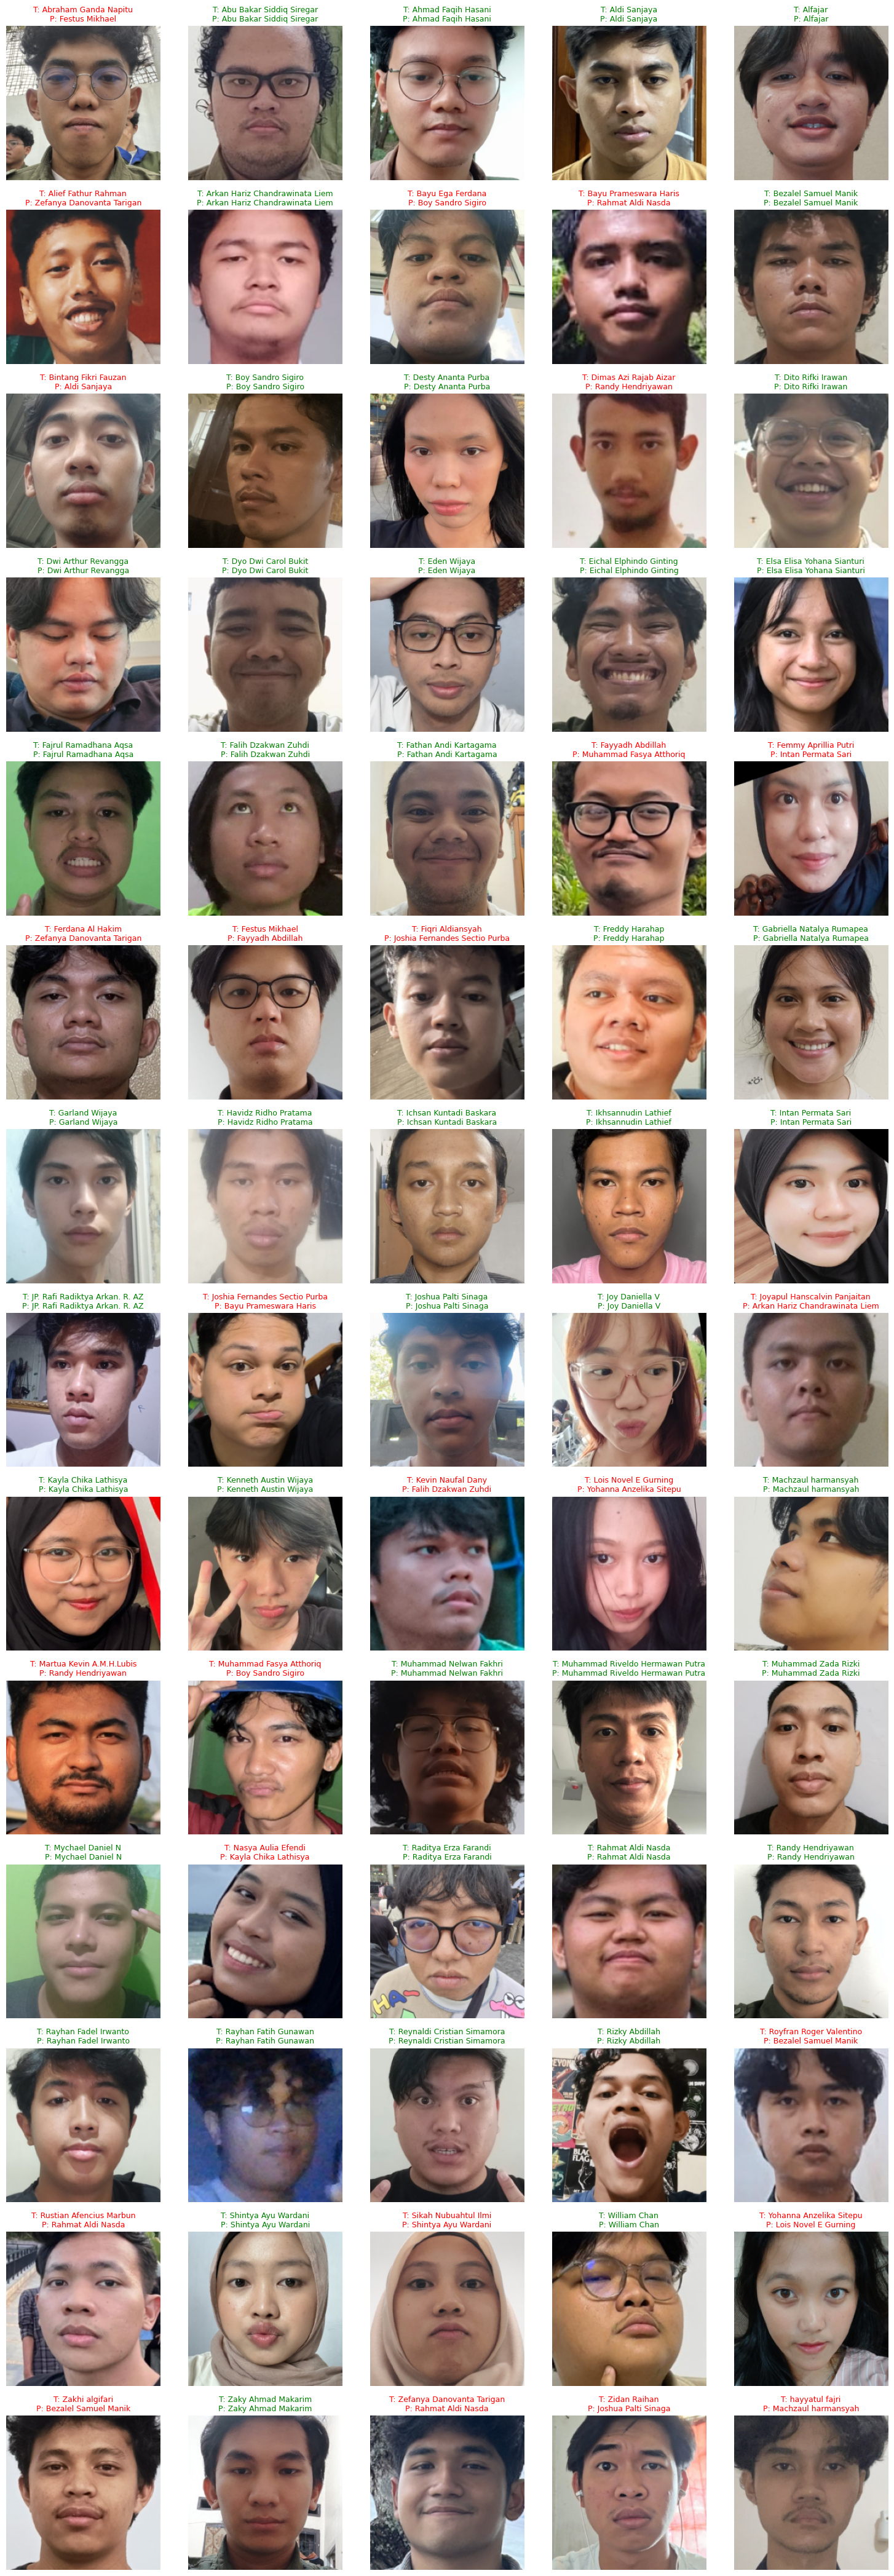

Displayed 70 images.


In [11]:
# ======================================================
# Cell 10 – Prediction Visualization
# ======================================================
import matplotlib.pyplot as plt

val_dataset = val_loader.dataset
idx_to_class = {v: k for k, v in label_map.items()}

IMAGENET_MEAN_T = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
IMAGENET_STD_T  = torch.tensor(IMAGENET_STD).view(3, 1, 1)

def denormalize(img_t: torch.Tensor) -> np.ndarray:
    img = img_t.cpu() * IMAGENET_STD_T + IMAGENET_MEAN_T
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    return img

# --- Grid settings ---
ROWS = 14
COLS = 5
MAX_SHOW = 70

model.eval()
images_shown = 0

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Preview Predictions"):
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits, _ = model(imgs, labels=None)
        preds = logits.argmax(1)

        for i in range(len(imgs)):
            if images_shown == 0:
                fig, axes = plt.subplots(
                    ROWS, COLS, figsize=(COLS * 3, ROWS * 3)
                )

            r = images_shown // COLS
            c = images_shown % COLS
            ax = axes[r, c]

            img_np = denormalize(imgs[i])
            true_idx = labels[i].item()
            pred_idx = preds[i].item()

            true_name = idx_to_class[true_idx]
            pred_name = idx_to_class[pred_idx]
            correct = (true_idx == pred_idx)

            ax.imshow(img_np)
            ax.set_title(
                f"T: {true_name}\nP: {pred_name}",
                fontsize=9,
                color=("green" if correct else "red"),
            )
            ax.axis("off")

            for spine in ax.spines.values():
                spine.set_edgecolor("green" if correct else "red")
                spine.set_linewidth(3)

            images_shown += 1
            if images_shown >= MAX_SHOW:
                break

        if images_shown >= MAX_SHOW:
            break

plt.tight_layout()
plt.show()
print(f"Displayed {images_shown} images.")
